In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from shark.utils import nb_init

nb_init()

INFO | nb_init | Set current dir to chess
INFO | nb_init | You are using Python 3.10.10 (main, Sep 14 2023, 16:59:47) [Clang 14.0.3 (clang-1403.0.22.14.1)]


# PPO againt on Inverted Double Pendulum

In [3]:
from loguru import logger
import os
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
import pandas as pd

from shark.models import PPOPendulum
from shark.utils import plot_metrics

## Create model

We choose the gymnasium environment here.

In [4]:
frame_skip = 1
frames_per_batch = frame_skip * 100
model = PPOPendulum(
    frame_skip=frame_skip,
    frames_per_batch=frames_per_batch,
)

## Rollout

We can immediately try to play, and check what playing returns.

In [5]:
rollout = model.env.rollout(3)
logger.info(f"Rollout of three steps: {rollout}")
logger.info(f"Shape of the rollout TensorDict: {rollout.batch_size}")
logger.info(f"Running policy: {model.policy_module(model.env.reset())}")
logger.info(f"Running value: {model.value_module(model.env.reset())}")

INFO | <module> | Rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([3, 11]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
                terminated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([3])

## Data

This is what a batch of data looks like.

In [6]:
# Collector
collector = model.train_dataloader()
for _, tensordict_data in enumerate(collector):
    logger.info(f"Tensordict data:\n{tensordict_data}")
    batch_size = int(tensordict_data.batch_size[0])
    assert batch_size == int(frames_per_batch // frame_skip)
    break

INFO | <module> | Tensordict data:
TensorDict(
    fields={
        action: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([100]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([100, 11]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        

In [7]:
# Training
trainer = pl.Trainer(
    accelerator="cpu",
    max_steps=8,
    val_check_interval=1,
    log_every_n_steps=1,
    logger=CSVLogger(
        save_dir="pytest_artifacts",
        name=model.__class__.__name__,
    ),
)
trainer.fit(model)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type               | Params
--------------------------------------------------------
0 | base_env         | TransformedEnv     | 0     
1 | env              | TransformedEnv     | 0     
2 | loss_module      | ClipPPOLoss        | 270 K 
3 | policy_module    | ProbabilisticActor | 135 K 
4 | value_module     | ValueOperator      | 134 K 
5 | advantage_module | GAE                | 0     
--------------------------------------------------------
270 K     Trainable params
0         Non-trainable params
270 K     Total params
1.080     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=16` reached.


In [8]:
# Get logged stuff
log_dir = trainer.log_dir
assert isinstance(log_dir, str)
logs = trainer.logged_metrics
assert isinstance(logs, dict)
logger.info(log_dir)
logger.info(logs)
filename = os.path.join(log_dir, "metrics.csv")
df = pd.read_csv(filename)
logger.info(df.head())

INFO | <module> | pytest_artifacts/PPOPendulum/version_19
INFO | <module> | {'loss_objective/train': tensor(-8.7905), 'loss_entropy/train': tensor(4.0836e-05), 'loss_critic/train': tensor(8.2905), 'loss/train': tensor(-49.9981), 'reward/train': tensor(8.9912), 'step_count/train': tensor(4.), 'reward/eval': tensor(8.9927), 'reward_sum/eval': tensor(35.9708), 'step_count/eval': tensor(3.)}
INFO | <module> |    epoch  loss/train  loss_critic/train  loss_entropy/train  \
0      0  -49.998589           8.856077            0.000090   
1      0  -49.997757           8.609015            0.000053   
2      0  -49.998245           8.827688            0.000099   
3      0  -49.997753           7.988828            0.000024   
4      0  -49.998329           8.427380           -0.000047   

   loss_objective/train  reward/eval  reward/train  reward_sum/eval  step  \
0             -9.356077     9.052899      8.993916        36.211597     0   
1             -9.109015     9.052899      8.993747        

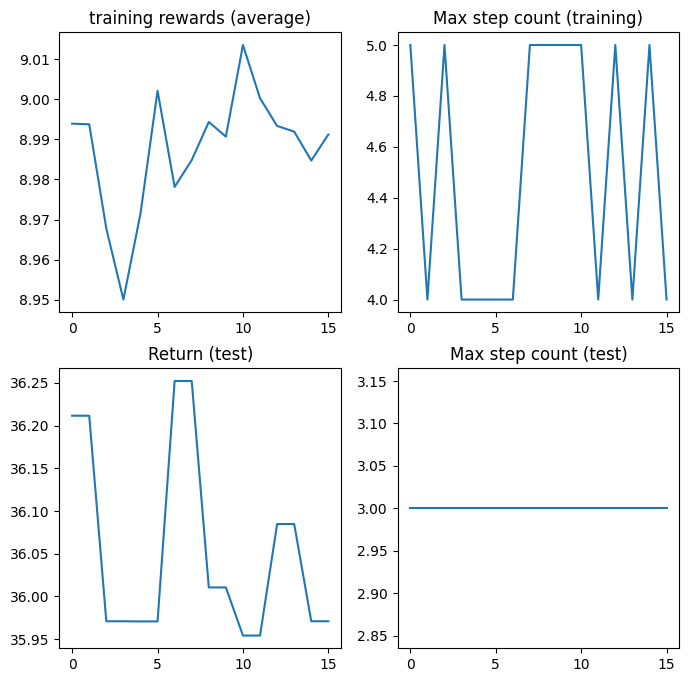

In [9]:
import matplotlib.pyplot as plt

# Plot
plot_metrics(df, show=True)